In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 7.1MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 7.3MB/s 
  Created wheel for wwf: filename=wwf-0.0.10-cp36-none-any.whl size=23155 sha256=f3e51f60020d1a036586b2aa1f89f012deea9ed9155d3797a6830fae2f572a43
  Stored in directory: /root/.cache/pip/wheels/c7/22/a7/30cb5077503f2c5d1c0af9187090604237d9e075154d833eb5
Successfully built wwf


In [2]:
!wget https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1 -O erm.zip

--2021-02-08 16:34:21--  https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/cb3g53z4pbtaqvl/erm.zip [following]
--2021-02-08 16:34:21--  https://www.dropbox.com/s/dl/cb3g53z4pbtaqvl/erm.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc611465e8c5dbe3b69d8f863df7.dl.dropboxusercontent.com/cd/0/get/BIgAxPRBhS9pA-GxCDmtwOKQVfTr5BeWnHNPwvIKgMpyVKBmeQIXnO2RwxDqDZMCkEbmazEvsVqbjrNXU9kCk1KnesGrloAvgxsqnfxt-a1JP5py8x2X7pbBy8kOBtbcuu8/file?dl=1# [following]
--2021-02-08 16:34:21--  https://uc611465e8c5dbe3b69d8f863df7.dl.dropboxusercontent.com/cd/0/get/BIgAxPRBhS9pA-GxCDmtwOKQVfTr5BeWnHNPwvIKgMpyVKBmeQIXnO2RwxDqDZMCkEbmazEvsVqbjrNXU9kCk1KnesGrloAvgxsqnfxt-a1JP5py8x2X7pbBy8kO

In [3]:
!unzip erm.zip

Archive:  erm.zip
   creating: dataset/
   creating: dataset/test/
   creating: dataset/test/no/
  inflating: dataset/test/no/anonymized_1421704.jpg  
  inflating: dataset/test/no/anonymized_336537.jpg  
  inflating: dataset/test/no/anonymized_569526.jpg  
  inflating: dataset/test/no/anonymized_196860.jpg  
  inflating: dataset/test/no/anonymized_920184.jpg  
  inflating: dataset/test/no/anonymized_1348815.jpg  
  inflating: dataset/test/no/anonymized_225304.jpg  
  inflating: dataset/test/no/anonymized_816099.jpg  
  inflating: dataset/test/no/anonymized_260226.jpg  
  inflating: dataset/test/no/anonymized_1619231.jpg  
  inflating: dataset/test/no/anonymized_1314755.jpg  
  inflating: dataset/test/no/anonymized_1182585.jpg  
  inflating: dataset/test/no/anonymized_656024.jpg  
  inflating: dataset/test/no/anonymized_198917.jpg  
  inflating: dataset/test/no/anonymized_246204.jpg  
  inflating: dataset/test/no/anonymized_324557.jpg  
  inflating: dataset/test/no/anonymized_492637.jpg

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('dataset/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=64)

In [14]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='efficientnet_b0')
]

In [15]:
import timm
timm.list_models('*efficientnet_b0*')

['efficientnet_b0',
 'tf_efficientnet_b0',
 'tf_efficientnet_b0_ap',
 'tf_efficientnet_b0_ns']

In [16]:
learn = timm_learner(dls512, 'efficientnet_b0',cbs = callbacks,metrics=[accuracy,Precision(),Recall()]).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


SuggestedLRs(lr_min=0.00014454397605732084, lr_steep=3.981071586167673e-06)

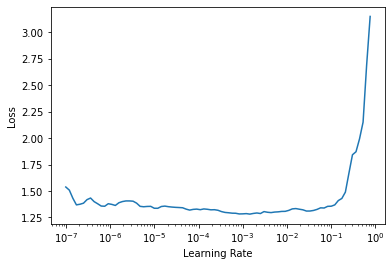

In [17]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.286792,0.938342,0.535168,0.575290,0.434402,00:24


Better model found at epoch 0 with valid_loss value: 0.9383420944213867.


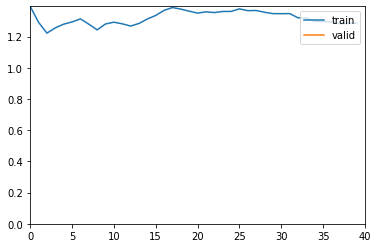

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.279703,0.945160,0.538226,0.565495,0.516035,00:27
1,1.280675,0.935171,0.547401,0.581315,0.489796,00:26
2,1.295081,0.916000,0.544343,0.575251,0.501458,00:26
3,1.280823,0.912435,0.538226,0.569966,0.486880,00:26
4,1.272924,0.904783,0.542813,0.574324,0.495627,00:26
5,1.265162,0.887383,0.551988,0.580128,0.527697,00:26
6,1.253532,0.896073,0.539755,0.569079,0.504373,00:25
7,1.220466,0.897301,0.541284,0.571429,0.501458,00:26
8,1.207603,0.882408,0.550459,0.580858,0.513120,00:26
9,1.232642,0.897154,0.544343,0.576792,0.492711,00:26


Better model found at epoch 0 with valid_loss value: 0.9451602697372437.


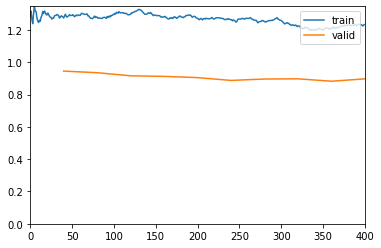

Better model found at epoch 1 with valid_loss value: 0.9351708889007568.
Better model found at epoch 2 with valid_loss value: 0.9159995913505554.
Better model found at epoch 3 with valid_loss value: 0.9124345183372498.
Better model found at epoch 4 with valid_loss value: 0.9047834873199463.
Better model found at epoch 5 with valid_loss value: 0.8873833417892456.
Better model found at epoch 8 with valid_loss value: 0.8824081420898438.


In [18]:
learn.fine_tune(10,base_lr=1e-5)

In [19]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

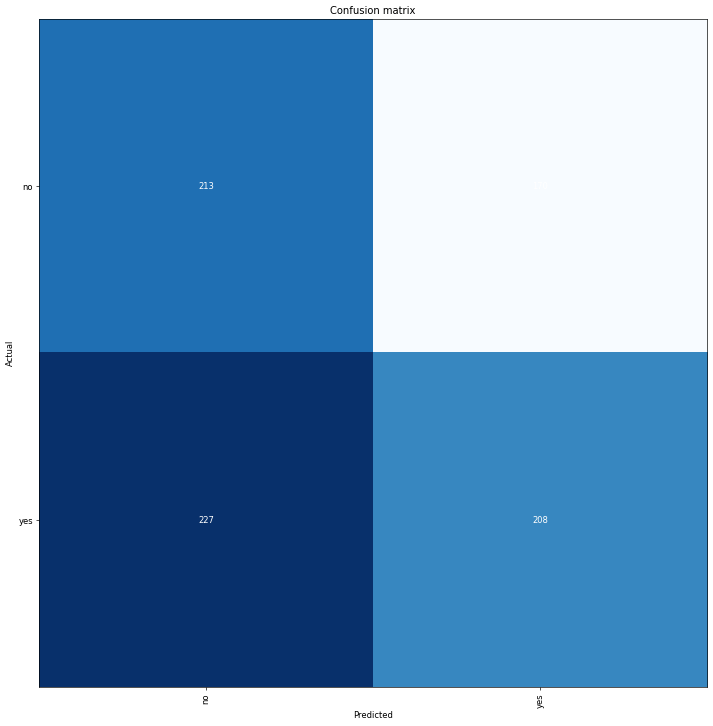

In [20]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [21]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5146699547767639.


(#4) [0.8996796011924744,0.5146699547767639,0.5502645502645502,0.4781609195402299]

In [22]:
learn.export(fname='resnet50.pkl')